In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats

import pandas as pd

import time

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200]

cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data['boolQuality'] = 0
data['boolQuality'][data['quality']>5] = 1

C:\Users\litwi\AppData\Local\Temp\ipykernel_23564\649372525.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['boolQuality'][data['quality']>5] = 1
C:\Users\litwi\AppData\Local\Temp\ipykernel_23564\649372525.py:14: SettingWithCopyWar

In [3]:
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None]

In [4]:
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

In [5]:
class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    self.input = nn.Linear(11,16)
    
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    self.output = nn.Linear(32,1)
  
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x)

In [6]:
def trainTheModel():
    
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  for epochi in range(numepochs):

    winenet.train()

    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      yHat = winenet(X)
      loss = lossfun(yHat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())

      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

    trainAcc.append( np.mean(batchAcc) )
    losses[epochi] = np.mean(batchLoss)

    winenet.eval()
    X,y = next(iter(test_loader))
    with torch.no_grad():
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  return trainAcc,testAcc,losses

In [7]:
from tqdm.auto import tqdm

numepochs = 500

batchsizes = [2,4,8,16,32,64,128,256,512]

accuracyResultsTrain = np.zeros((numepochs,len(batchsizes)))
accuracyResultsTest  = np.zeros((numepochs,len(batchsizes)))
comptime             = np.zeros(len(batchsizes))

# TO EXCLUDE RANDOMNESS
test_loader = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

for batch in tqdm(range(len(batchsizes))):

  starttime = time.process_time()

  train_loader = DataLoader(train_dataDataset,batch_size=int(batchsizes[batch]), shuffle=True, drop_last=True)

  winenet = ANNwine()
  trainAcc,testAcc,losses = trainTheModel()

  accuracyResultsTrain[:,batch] = trainAcc
  accuracyResultsTest[:,batch]  = testAcc

  comptime[batch] = time.process_time() - starttime

C:\Users\litwi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [14:32<00:00, 96.93s/it]


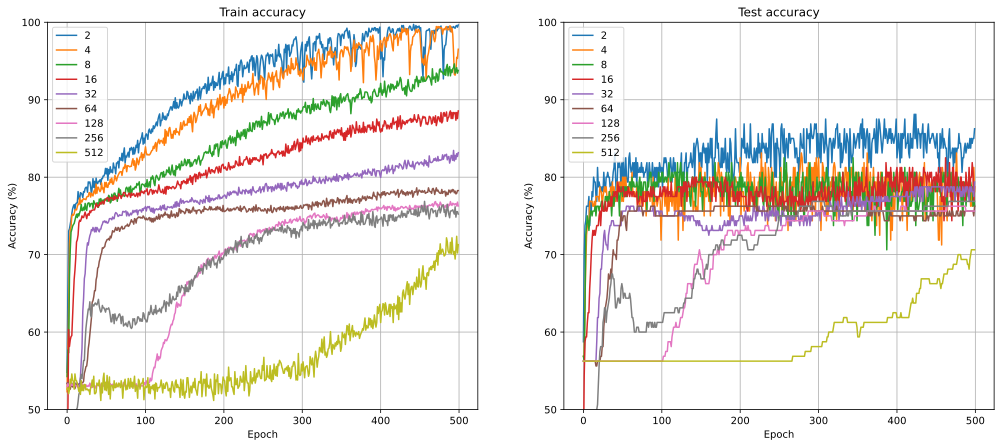

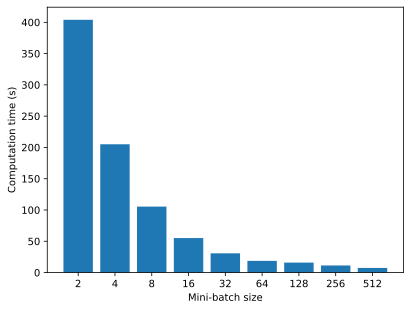

In [8]:
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

for i in range(2):
  ax[i].legend(batchsizes)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,100])
  ax[i].grid()

plt.show()



plt.bar(range(len(comptime)),comptime,tick_label=batchsizes)
plt.xlabel('Mini-batch size')
plt.ylabel('Computation time (s)')
plt.show()